## socarvision upstream representation에 적용
- 마지막 conv layer값을 activation 값으로 가져와서 similarity 계산하는 방식
- 비교하고자 하는 representation (=weight)
    - model_activations/socarvision_Upstream dir만들고
    - 비교하고자 하는 weight 저장해두기
- 시각화 방법
    - (1) 마지막 conv layer (=activate layer) 만 비교하여 Net1 v. Net2 를 비교하는 경우 : 구현완료
    - (2) 전체 레이어를 비교하는 경우 

In [1]:
# for CKA
import os
import numpy as np
import pickle
import gzip
import cca_core
from CKA import linear_CKA, kernel_CKA

# for model
import torch
import torch.nn as nn
from torchvision import transforms as T
from torchvision.models import resnet50
import cv2
import random
import math
import pandas as pd
from PIL import Image

device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# seed 고정 (학습때와 동일하게)
manual_seed = 42
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed_all(manual_seed)

Random Seed:  42


In [ ]:
# Accuracy 기준 best checkpoint 로드

## X : 비교하고자 하는 첫번째 모델
net1 = resnet50(pretrained = False)
best_checkpoint1 = 'model_activations/socarvision_Upstream/2class_resnet50_acc_70_byol_pretrain_true.pth'
net1.load_state_dict(torch.load(best_checkpoint1, map_location=device))
net1 = net1.to(device)
net1 =net1.eval()

## Y : 비교하고자 하는 두번째 모델
net2 = resnet50()
best_checkpoint2 = 'model_activations/socarvision_Upstream/2class_resnet50_acc90_rotnet_pretrain_true.pth'
in_features = net2.fc.in_features
net2.fc = nn.Sequential(nn.Linear(in_features,4))
net2.load_state_dict(torch.load(best_checkpoint2, map_location=device))
net2 = net2.to(device)
net2 = net2.eval()

In [ ]:
# 모델 net1, net2에서 activate layer weight값을 가져옴
print('-'*60)
for l in list(net1.named_parameters()):
    print(l[0], ':', l[1].detach().numpy().shape)
    
    # 마지막 conv layer activate vector가져오기
    if l[0] == "layer4.2.conv3.weight" :
        activate_vector_1 = l[1].detach().numpy()

print('-'*60)
for l in list(net2.named_parameters()):
    print(l[0], ':', l[1].detach().numpy().shape)
    
    # 마지막 conv layer activate vector가져오기
    if l[0] == "layer4.2.conv3.weight" :
        activate_vector_2 = l[1].detach().numpy()

In [ ]:
## shape check
print(activate_vector_1.shape)
print(activate_vector_2.shape)

In [ ]:
avg_acts1 = np.mean(activate_vector_1, axis=(1,2))
avg_acts2 = np.mean(activate_vector_2, axis=(1,2))
print(avg_acts1.shape, avg_acts2.shape)

In [ ]:
# CKA
print('Linear CKA: {}'.format(linear_CKA(avg_acts1, avg_acts2)))
print('RBF Kernel CKA: {}'.format(kernel_CKA(avg_acts1, avg_acts2)))

# CCA
a_results = cca_core.get_cca_similarity(avg_acts1.T, avg_acts2.T, epsilon=1e-10, verbose=False)
print("Mean CCA similarity", np.mean(a_results["cca_coef1"]))

### 여러 weight( > 2개)간의 CKA 확인
- models_activations/socarvision_Upstream/upstream에 비교하고자 하는 모든 weight 저장

In [30]:
model_activation_root = "models_activations/socarvision_Upstream/upstream"

all_sim_list = list()

for weight_file_1 in os.listdir(model_activation_root) :
    tmp_list = list()
    for weight_file_2 in os.listdir(model_activation_root) :
        
        if weight_file_1 == weight_file_2 : 
            tmp_list.append(1)
            pass
        else : 
            # 각 모델 weight weight 불러오기
            net1 = resnet50(pretrained = False)
            best_checkpoint1 = os.path.join(model_activation_root, weight_file_1)
            if 'rotnet' in weight_file_1 : 
                in_features = net1.fc.in_features
                net1.fc = nn.Sequential(nn.Linear(in_features,4))
            elif 'byol' in weight_file_1 : 
                pass
            elif 'stanfordcar' in weight_file_1 : 
                in_features = net1.fc.in_features
                net1.fc = nn.Linear(in_features,196)
            net1.load_state_dict(torch.load(best_checkpoint1, map_location=device))
            net1 = net1.to(device)
            net1 =net1.eval()

            net2= resnet50(pretrained = False)
            best_checkpoint2 = os.path.join(model_activation_root, weight_file_2)
            if 'rotnet' in weight_file_2 : 
                in_features = net2.fc.in_features
                net2.fc = nn.Sequential(nn.Linear(in_features,4))
            elif 'byol' in weight_file_2 : 
                pass
            elif 'stanfordcar' in weight_file_2 : 
                in_features = net2.fc.in_features
                net2.fc = nn.Linear(in_features,196)
            net2.load_state_dict(torch.load(best_checkpoint2, map_location=device))
            net2 = net2.to(device)
            net2 =net2.eval()
            
            # 모델에서 activation vector 불러옴
            for l in list(net1.named_parameters()):
                if l[0] == "layer4.2.conv3.weight" :
                    activate_vector_1 = l[1].detach().numpy()
                    
            for l in list(net2.named_parameters()):
                if l[0] == "layer4.2.conv3.weight" :
                    activate_vector_2 = l[1].detach().numpy()
            
            # shape 변경
            avg_acts1 = np.mean(activate_vector_1, axis=(1,2))
            avg_acts2 = np.mean(activate_vector_2, axis=(1,2))
            
            # 결과 확인
            print('='*120)
            print('>> ', weight_file_1,'v.', weight_file_2)
            # CKA
            print('Linear CKA: {}'.format(linear_CKA(avg_acts1, avg_acts2)))
            print('RBF Kernel CKA: {}'.format(kernel_CKA(avg_acts1, avg_acts2)))

            # CCA
            a_results = cca_core.get_cca_similarity(avg_acts1.T, avg_acts2.T, epsilon=1e-10, verbose=False)
            print("Mean CCA similarity", np.mean(a_results["cca_coef1"]))
            print('='*120)
            
            tmp_list.append(nkernel_CKA(avg_acts1, avg_acts2))
            
    all_sim_list.append(tmp_list)

>>  2class_resnet50_acc_56_rotnet_pretrain_false.pth v. 2class_resnet50_acc90_rotnet_pretrain_true.pth
Linear CKA: 0.006019999132772269
RBF Kernel CKA: 0.0019526805503856106
Mean CCA similarity 0.07758865324382828
>>  2class_resnet50_acc_56_rotnet_pretrain_false.pth v. resnet50_acc91_stanfordcar_pretrain_true.pth
Linear CKA: 0.005705053381358424
RBF Kernel CKA: 0.0018674075184957491
Mean CCA similarity 0.07553180331335999
>>  2class_resnet50_acc_56_rotnet_pretrain_false.pth v. 10class_resnet50_acc_49_rotnet_pretrain_false.pth
Linear CKA: 0.013533825056765484
RBF Kernel CKA: 0.005343304386722878
Mean CCA similarity 0.11633496904580257
>>  2class_resnet50_acc_56_rotnet_pretrain_false.pth v. 2class_resnet50_acc_70_byol_pretrain_true.pth
Linear CKA: 0.0002358672263921652
RBF Kernel CKA: 0.0016117159424035583
Mean CCA similarity 0.015357969961064344
>>  2class_resnet50_acc_56_rotnet_pretrain_false.pth v. 2class_resnet50_acc_63_byol_pretrain_false.pth
Linear CKA: 1.667136893226811e-05
RBF Ke

In [31]:
cm = np.array(all_sim_list)
print('>> check sim arr shape check :', cm.shape) 

>> check sim arr shape check : (8, 8)


In [32]:
cm_df = pd.DataFrame(cm)
cm_df.to_csv('cka_df.csv', index = False)

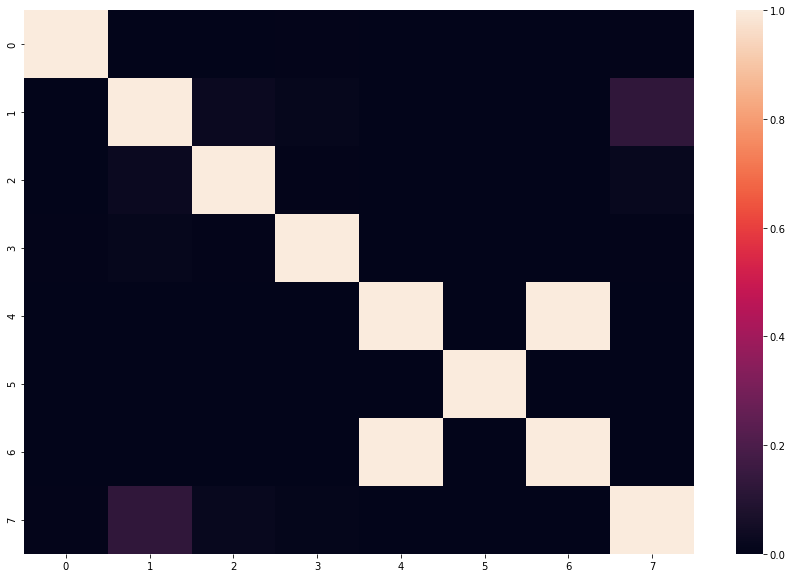

In [33]:
# 결과 히트맵으로 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15,10))
sns.heatmap(scaled_cm)
plt.show()     